In [4]:
# 完成了3D模型的搭建
# 在这个里面，测试了3D模型是否正常，正在测试loss是否改为3D
# 

import torch
import torch.nn as nn
import torchvision
import torch.optim
import os
import sys
import argparse
import time
import dataloader
import model_3D
import Myloss_3D
import numpy as np
from PIL import Image
import glob
import time
import cv2
import tifffile as tiff


def get_img(path):    #读取tiff格式和其它格式图片，主要为3维16位图片
    if 'tif' in path:
        img = tiff.imread(path)
    else:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    
    img = torch.tensor(img/65536)
    img = img[0:32, 0:32, 0:32]

    img = img[np.newaxis, np.newaxis, :, :, :]
    
#     img = img.permute(2, 0, 1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    img = img.to(device)
    
    return img


def weights_init(m):     # 初始化模型参数
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def model_init():
    DCE_net = model_3D.enhance_net_nopool()
#     print(DCE_net)
    
    DCE_net.apply(weights_init)
    
    DCE_net = DCE_net.double()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
    DCE_net = DCE_net.to(device)
    
    return DCE_net

def train_simulate():  # 开始训练，主要是不想把这个写在main里面
    img_path = 'data/883.tif'
    img = get_img(img_path)
    print('图像尺寸{}，图像类型{}'.format(img.shape, img.dtype))
    start = time.time()
    
    # ---------------------计算loss---------------------------
    L_color = Myloss_3D.L_color()
    L_spa = Myloss_3D.L_spa()
    L_exp = Myloss_3D.L_exp(16,0.6)
    L_TV = Myloss_3D.L_TV()
    # --------------------------------------------------------
    
    DCE_net = model_init()
    
    
    enhanced_image_1,enhanced_image,A  = DCE_net(img)      # from train
    print('enhanced_image_1:{} enhanced_image:{} A:{}'.format(enhanced_image_1.size(),enhanced_image.size(),A.size()))
    
    print('L_spa的输入参数：enhance.shape:{}, lowlight.shape{}'.format(enhanced_image.shape, img.shape))

    torch.save(A, 'A')
#     _,enhanced_image,_ = DCE_net(data_lowlight)                     #图像增强forward，DCE_net是上几行导入的
    data_lowlight = img
    Loss_TV = 200*L_TV(A)   
#     loss_col = 5*torch.mean(L_color(enhanced_image))         #不需要颜色一致性损失
    loss_exp = 10*torch.mean(L_exp(enhanced_image))
    loss_spa = torch.mean(L_spa(enhanced_image, data_lowlight))

    # best_loss
    loss =  Loss_TV + loss_spa + loss_exp
    print('Loss_TV： {} loss_spa： {}  loss_exp： {}'.format(Loss_TV , loss_spa ,loss_exp))

    end_time = (time.time() - start)
    print('用时：',end_time)
    
    
    
    
if __name__ == '__main__':
    train_simulate()





图像尺寸torch.Size([1, 1, 32, 32, 32])，图像类型torch.float64
enhanced_image_1:torch.Size([1, 1, 32, 32, 32]) enhanced_image:torch.Size([1, 1, 32, 32, 32]) A:torch.Size([1, 24, 32, 32, 32])
L_spa的输入参数：enhance.shape:torch.Size([1, 1, 32, 32, 32]), lowlight.shapetorch.Size([1, 1, 32, 32, 32])
L_TV tensor(0.0066, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.3598, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
enhance_pool.shape:torch.Size([1, 1, 8, 8, 8]), org_pool.shape:torch.Size([1, 1, 8, 8, 8])
Loss_TV： 1.3205369802053737 loss_spa： 5.808102995140262e-12  loss_exp： 3.5984840151009356
用时： 0.27377986907958984


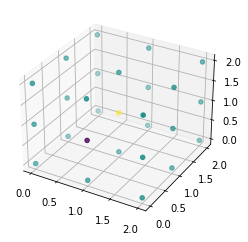

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D array
arr = np.array([[[0,0,0],[0,0,0],[0,0,0]],[[0,-1,0],[0,1,0],[0,0,0]],
                                          [[0,0,0],[0,0,0],[0,0,0]]])

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y, z = np.indices(arr.shape)
ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=arr.flatten())
plt.show()